In [7]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import gym_super_mario_bros
from tqdm import tqdm
import pickle 

%matplotlib inline
import time
import pylab as pl
from IPython import display as disp
from collections import deque

from IPython import embed
import pickle

from Wrappers import refined_env

In [8]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Net, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Sequential(
            nn.Conv2d(input_dim[0], 32, kernel_size=8, stride=4),self.relu,
            nn.Conv2d(32, 64, kernel_size=4, stride=2),self.relu,
            nn.Conv2d(64, 64, kernel_size=3, stride=1),self.relu
        )
        self.fc = nn.Sequential(
            nn.Linear(64*7*7, 512),self.relu,
            nn.Linear(512, output_dim)       
        )
    def forward(self, x):
        conv_out = self.conv(x)
        reshape_conv_out = torch.reshape(conv_out,(1,-1))
        out = self.fc(reshape_conv_out)
        return out


In [9]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = refined_env(env)
state_space = env.observation_space.shape
action_space = env.action_space.n
batch_size=32
gamma=0.90
lr=0.00025
epsilon_min=0.02
epsilon_decay=0.99
replay_memory_size=30000
copy_to_target = 50

In [10]:
def show_state(env, step=0):
    # Show Mario playing
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Step: {}".format(step))
    plt.axis('off')
    disp.clear_output(wait=True)
    disp.display(plt.gcf())
    

In [11]:
class DDQN:

    def __init__(self, load_model, steps_exec):
        self.policy_network = Net(state_space, action_space)
        self.target_network = Net(state_space, action_space)
        self.optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=lr)
        self.steps_exec = steps_exec
        self.epsilon = 1
        if load_model:
#             self.policy_network.load_state_dict(torch.load("DQN1_{}.pth".format(steps_exec, map_location=torch.device('cpu'))))
#             self.target_network.load_state_dict(torch.load("DQN2_{}.pth".format(steps_exec, map_location=torch.device('cpu'))))
            self.policy_network.load_state_dict(torch.load("DQN1_{}.pth".format(steps_exec)))#, map_location=torch.device(self.device)))
            self.target_network.load_state_dict(torch.load("DQN2_{}.pth".format(steps_exec)))#, map_location=torch.device(self.device)))
            self.optimizer.load_state_dict(torch.load("optimizer_{}.pth".format(steps_exec)))
            with open("replay_memory_{}.pkl".format(steps_exec), 'rb') as f:
                self.replay_memory = pickle.load(f)
#                 print(len(self.replay_memory),self.replay_memory[0])
            self.epsilon *= epsilon_decay**steps_exec
            
        else:
            self.replay_memory = collections.deque(maxlen=replay_memory_size)
                                                   
        self.L1 = nn.SmoothL1Loss()
        self.env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
        self.env = refined_env(self.env)

     
    def update_nn(self, batch):
        
        for state, action, reward, next_state, done in batch:
            
            target = reward + torch.mul((gamma * self.target_network(next_state).max(1).values.unsqueeze(1)),  1 - done)
            output = self.policy_network(state).gather(1, action.long())
          
            self.optimizer.zero_grad()  
            loss = self.L1(output, target)
            loss.backward()
            self.optimizer.step()
            

    def train(self,num_episodes=100):
   
            num_episodes = num_episodes
            env.reset()
            
            metrics['total_rewards'] = []
            metrics['epsilon_decay'] = []

            if self.steps_exec:
                with open("total_rewards_{}.pkl".format(self.steps_exec), 'rb') as f:
                    metrics["total_rewards"] = pickle.load(f)
                    print(len(metrics["total_rewards"]))
                # with open("epsilon_decay_{}.pkl".format(self.steps_exec), 'rb') as f:
                #     metrics["epsilon_decay"] = pickle.load(f)
                # self.epsilon = metrics["epsilon_decay"][-1]
            
            for ep_num in tqdm(range(num_episodes)):
                
                state = self.env.reset()
                state = torch.Tensor([state])
                total_reward = 0
                steps = 0

                if ep_num%copy_to_target == copy_to_target-1:
                    self.target_network.load_state_dict(self.policy_network.state_dict())
                    
                if self.steps_exec%100 == 99: # Prioritizing experiences with low rewards
                    self.replay_memory = sorted(self.replay_memory, key = lambda x: x[2], reverse=True)

                done = False
                if ep_num%50 == 49 or metrics['total_rewards'][-1] >= 2500:
                  with open("replay_memory_{}.pkl".format(self.steps_exec), "wb") as f:
                      pickle.dump(self.replay_memory, f)
                  with open("total_rewards_{}.pkl".format(self.steps_exec), "wb") as f:
                      pickle.dump(metrics['total_rewards'], f)
                
                  torch.save(self.policy_network.state_dict(), "DQN1_{}.pth".format(self.steps_exec))
                  torch.save(self.target_network.state_dict(), "DQN2_{}.pth".format(self.steps_exec))
                  torch.save(self.optimizer.state_dict(), "optimizer_{}.pth".format(self.steps_exec))

                while not done:
                    
                    if random.random() < self.epsilon:  
                        action = torch.tensor([[random.randrange(action_space)]])
                    else:
                        action = torch.argmax(self.policy_network(state)).unsqueeze(0).unsqueeze(0).cpu()
                    steps += 1
                    
                    next_state, reward, done, info = self.env.step(int(action[0]))
                    total_reward += reward

                    next_state = torch.Tensor([next_state])
                    reward = torch.tensor([reward]).unsqueeze(0)
                    done = torch.tensor([int(done)]).unsqueeze(0) 
                    self.replay_memory.append([state.float(), action.float(), reward.float(), next_state.float(), done.float()])
                    if len(self.replay_memory) > replay_memory_size:
                        self.replay_memory = self.replay_memory[-replay_memory_size:]
                    if batch_size > len(self.replay_memory):
                        pass
                    else:
                        batch = random.choices(self.replay_memory, k=batch_size)
                        if self.epsilon > epsilon_min:
                            self.epsilon *= epsilon_decay
                        metrics["epsilon_decay"].append(self.epsilon)
                        self.update_nn(batch)
                    
                    state = next_state
                    
                self.steps_exec += 1
                metrics['total_rewards'].append(total_reward)
                print(total_reward)
                
            with open("replay_memory_{}.pkl".format(self.steps_exec), "wb") as f:
                pickle.dump(self.replay_memory, f)
            with open("total_rewards_{}.pkl".format(self.steps_exec), "wb") as f:
                pickle.dump(metrics['total_rewards'], f)
            with open("epsilon_decay_{}.pkl".format(self.steps_exec), "wb") as f:
                pickle.dump(metrics['epsilon_decay'], f)
          
            torch.save(self.policy_network.state_dict(), "DQN1_{}.pth".format(self.steps_exec))
            torch.save(self.target_network.state_dict(), "DQN2_{}.pth".format(self.steps_exec))
            torch.save(self.optimizer.state_dict(), "optimizer_{}.pth".format(self.steps_exec))

In [12]:
def train(load_model, steps_exec, num_episodes):
      agent = DDQN(load_model = load_model, steps_exec=steps_exec)
      agent.train(num_episodes=num_episodes)

In [14]:
metrics = {}
train(load_model=True, steps_exec=4404, num_episodes=1)

In [15]:
def execute(policy_path):
      policy_network = Net(state_space, action_space)
      policy_network.load_state_dict(torch.load("{}".format(policy_path), map_location=torch.device('cpu')))
      state = env.reset()
      state = torch.Tensor([state])
      done = False
      steps = 0
      total_reward = 0
      while not done:
          show_state(env, steps)
          action = torch.argmax(policy_network(state)).unsqueeze(0).unsqueeze(0).cpu()
          # print(action)
          state_next, reward, done, info = env.step(int(action[0]))
          # print(reward,done)
          total_reward += reward
          state = torch.Tensor([state_next])
          steps += 1
      print(total_reward)

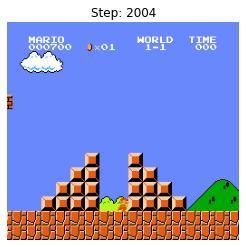

1771.0


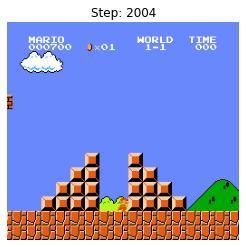

In [17]:
execute("DQN1_4404.pth")

In [20]:
 metrics = {}
 with open("total_rewards_4404.pkl", 'rb') as f:
      metrics["total_rewards"] = pickle.load(f)
      print(np.average(metrics["total_rewards"]))

metric_avg = []   
for i in range(len(metrics["total_rewards"])):
    metric_avg.append(np.average(metrics["total_rewards"][:i+1]))

1044.7091280653951


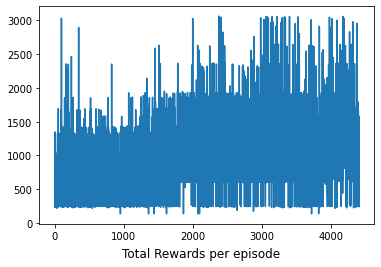

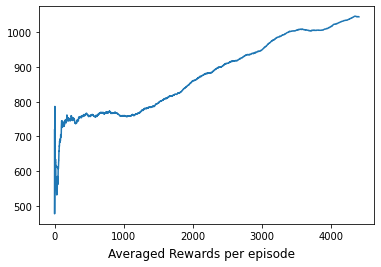

In [21]:
%matplotlib inline
plt.plot(metrics["total_rewards"])
plt.figtext(0.5, 0.01, "Total Rewards per episode", wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig('total_rewards.png')
plt.show()

plt.plot(metric_avg)
plt.figtext(0.5, 0.01, "Averaged Rewards per episode", wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig('total_rewards.png')
plt.show()